Text Mining and Analysis of Financial Annual Reports
====================================================

In [2]:
import fitz #pymupdf
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoLocator, MultipleLocator, MaxNLocator
from wordcloud import WordCloud
import unicodedata
import time
import nltk
from nltk.corpus import stopwords
import textwrap
import math

**NLTK requires a one-time download of stopwords**

In [3]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/george/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Definitions


This is not an exhaustive list and is wholly defined by frequently appearing terms I have found in financial documents. 

In [4]:
search_terms = {
"Liquidity": ["funding", "flows", "cash", "liquid reserves", "repo", "haircut", "cashflows", "drawdowns", "outflows", "inflows", "runoff", "crunch", "drain", "buffer", "collateral"],
"Capital": ["buffers", "capital ratios","capital reserves", "capital requirements", "cushion", "CET1", "Tier 1", "Tier 2", "Tier 3", "capital adequacy", "capital adequacy ratio", "CAR", "capital ratio", "capital position", "capital base", "capital structure", "capital management", "capital planning", "capital allocation", "capital optimization", "capital efficiency", "capital generation", "capital deployment", "capital return", "capital distribution"],
"Credit": ["loans", "lending", "asset quality", "obligor", "counterparty", "exposures", "net exposure","NPL", "nonperforming", "impairment", "cedants", "default", "credit risk", "credit losses", "credit provisions", "credit reserves", "credit requirements"],
"Foreign Exchange": ["forex", "fx", "currency", "exchange rates","currency pairs", "currency risk", "currency exposure", "currency fluctuations", "currency volatility", "currency hedging", "currency swaps", "currency forwards", "currency options", "currency derivatives", "currency contracts", "currency markets", "currency trading", "currency speculation", "currency manipulation", "currency intervention", "currency peg", "currency basket", "currency band", "currency board", "currency union", "currency crisis", "currency war", "currency controls", "currency devaluation", "currency appreciation", "currency depreciation", "currency revaluation", "currency reserve", "currency swap", "currency peg", "currency basket", "currency band", "currency board", "currency union", "currency crisis", "currency war", "currency controls", "currency devaluation", "currency appreciation", "currency depreciation", "currency revaluation", "currency reserve", "currency swap"],
"Regulatory Risk": ["rules", "regulation", "standard", "compliance", "litigation", "enforcement", "supervision", "regulatory", "regulators",],
"Insurance": ["insurance", "underwriting", "premium", "claims", "lapse", "morbidity", "mortality", "longevity", "catastrophe"],
"Operational Risk": ["operational", "resilience", "cyber", "information", "security", "outsourcing", "third party", "reliance", "continuity", "pandemic", "disaster", "people", "processes", "systems", "data", "technology", "infrastructure", "IT", "fraud", "theft", "error", "disruption", "failure", "malicious", "attack","AI"],
"ESG": ["ESG", "environmental", "social", "governance", "sustainability", "green", "climate", "carbon", "emissions", "pollution", "waste", "biodiversity", "conservation", "renewable", "energy", "solar", "wind", "water", "sustainable", "greenhouse", "emissions", "carbon", "footprint", "greenwashing"],
}

# Text extraction

**Data source: JPM Annual Report 2022**

In [5]:
def extractPDF(doc):
    doc = fitz.open(doc)
    text = ""
    for page in doc:
        text = text + page.get_text()    
    
    # convert to lowercase
    text = text.lower()
    # remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # remove numbers
    text = re.sub(r'\d+', '', text)
    # remove  whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # remove NLTK defined stopwords (e.g, "and", "the", "is")
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

## Data Cleaning

In [6]:
def searchPDF(text):
    results = []
    # iterate the text for each term, add to results[]
    for category, words in search_terms.items():
        for word in words:
            presence = word in text
            frequency = text.count(word)
            results.append([word,category,presence,frequency]) 

    # convert results[] to a pandas df to plot
    df = pd.DataFrame(results, columns=["SearchTerm","Category","Presence", "Frequency"])
    return df

jpm_df = searchPDF(extractPDF('src/jpm/NYSE_JPM_2022.pdf'))
print(jpm_df)


          SearchTerm   Category  Presence  Frequency
0            funding  Liquidity      True        104
1              flows  Liquidity      True         97
2               cash  Liquidity      True        287
3    liquid reserves  Liquidity     False          0
4               repo  Liquidity      True        305
..               ...        ...       ...        ...
168       greenhouse        ESG     False          0
169        emissions        ESG      True          3
170           carbon        ESG      True          8
171        footprint        ESG      True          2
172     greenwashing        ESG     False          0

[173 rows x 4 columns]


# Visualisation

## Setting global rcParams

In [7]:
plt.rcParams['figure.facecolor'] = '#12273F' 
plt.rcParams['axes.facecolor'] = '#12273F'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.edgecolor']='#FFFFFF'
plt.rcParams['axes.labelcolor']='#FFFFFF'
plt.rcParams['text.color']='#FFFFFF'
plt.rcParams['xtick.color']='#FFFFFF'
plt.rcParams['ytick.color']='#FFFFFF'

## Finding frequent terms, ordered by respective category 

In [8]:
category_count = jpm_df.groupby(['Category'])['Frequency'].sum().to_dict() # get the sum of the frequency for each category
# convert df to dict so we can plot
for category, frequency in category_count.items():
    print(category, frequency)

Capital 168
Credit 1929
ESG 262
Foreign Exchange 91
Insurance 95
Liquidity 1115
Operational Risk 1041
Regulatory Risk 500


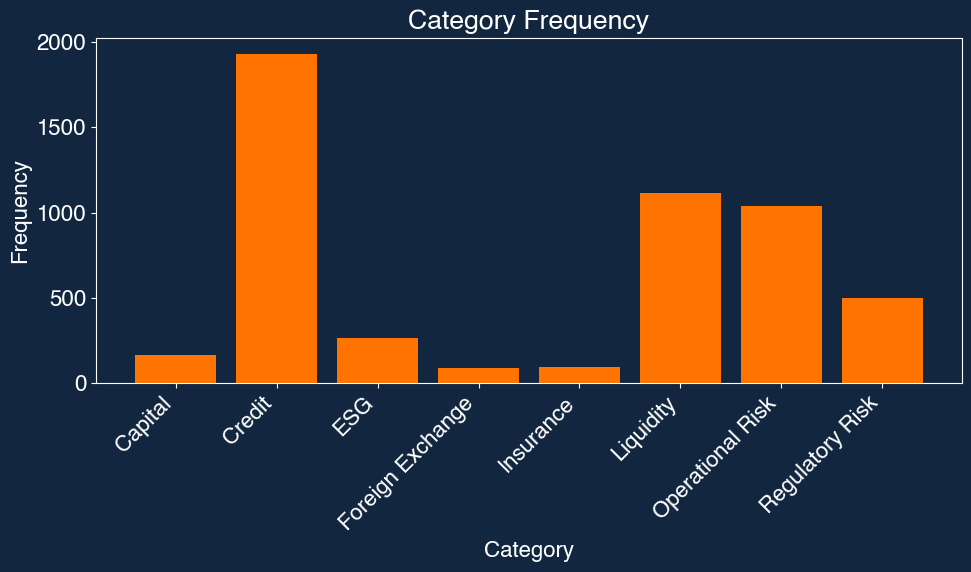

In [9]:
def plot_category_frequency(df):
    category_count = df.groupby(['Category'])['Frequency'].sum().to_dict()
    #for category, frequency in category_count.items():
        #print(category, frequency)

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(x=list(category_count.keys()), height=list(category_count.values()), color='#FF7300')
    plt.title('Category Frequency')
    plt.xlabel('Category')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.gca().yaxis.set_major_locator(MultipleLocator(500))
    plt.tight_layout()
    plt.show()

plot_category_frequency(jpm_df)

## Individual words

In [10]:
def plot_category(n, category, df, ax=None):
    category_df = df[df['Category'] == category]
    category_df = category_df[category_df['Frequency'] > 0] # a top n analysis may include terms with zero frequency, so we filter them out
    category_df = category_df.sort_values(by='Frequency', ascending=False)
    
    available_terms = len(category_df) 
    n_terms = min(n, available_terms)  # for example, top 10 terms in FX include terms with zero frequency, 
    #...so we only plot top 8, as the other 2 potential terms will always have zero frequency
    
    top_words = category_df.iloc[:n_terms]['SearchTerm']
    top_frequencies = category_df.iloc[:n_terms]['Frequency']

    if ax is None: # if no axis is provided (i.e, when we are not using subplots), create a new figure and axis for use in a standalone plot
        ax = plt.gca()
        
    ax.bar(top_words, top_frequencies, color='#FF7300')
    ax.set_title(category, color='white')
    ax.set_xlabel('Term', color='white')
    ax.set_ylabel('Frequency', color='white')
    ax.tick_params(axis='x', rotation=45, colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.yaxis.set_major_locator(AutoLocator())
    ax.yaxis.set_minor_locator(MultipleLocator(1))
    
    return ax

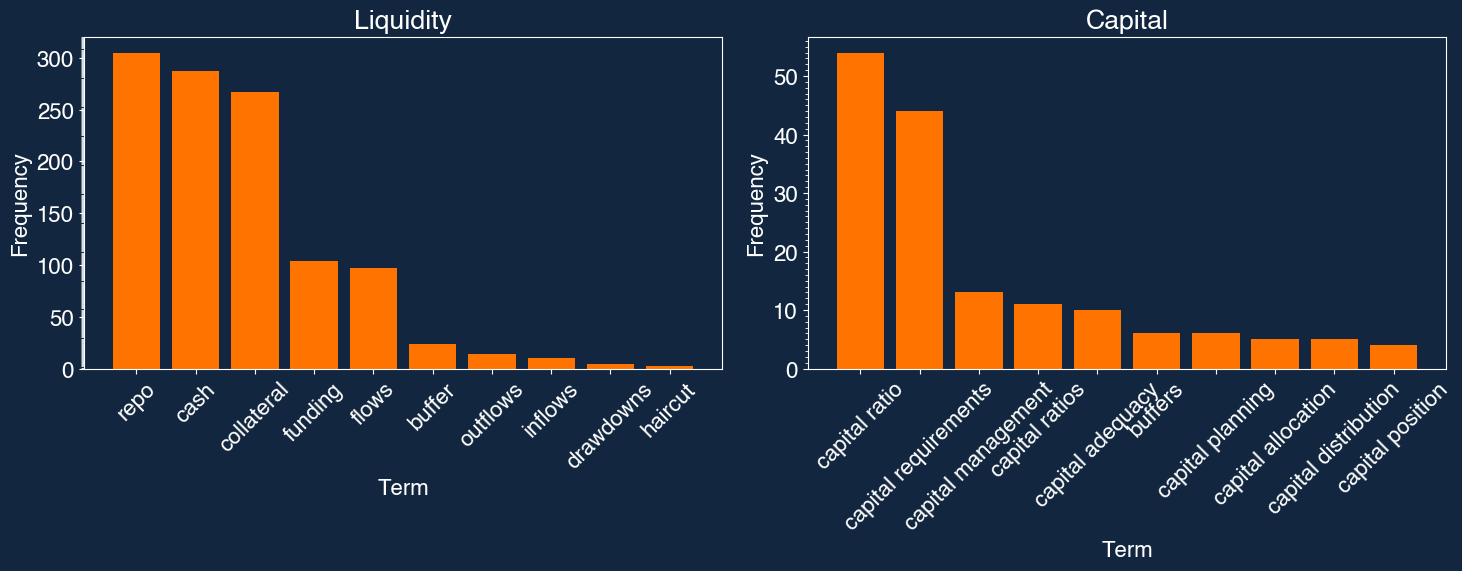

In [11]:
#liquidity, capital plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_category(10, 'Liquidity', jpm_df, ax1)
plot_category(10, 'Capital', jpm_df, ax2)

plt.tight_layout()
plt.show()

Whilst the liquidity graph fails to tell us much, the capital graph suggests heavy usage of capital ratios/requirements. \
This does not tell us much, however n-gram analysis may assist in understanding the context behind these occurrences.

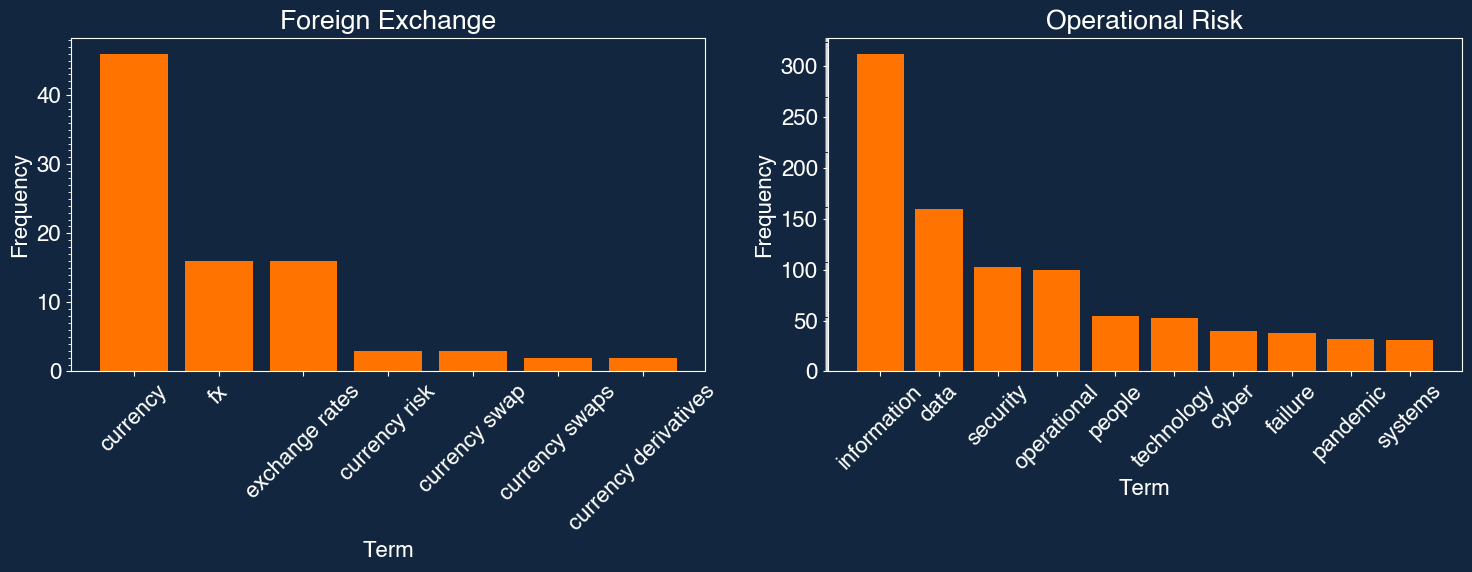

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
plot_category(10, 'Foreign Exchange', jpm_df, ax1)
plot_category(10, 'Operational Risk', jpm_df, ax2)

plt.tight_layout()
plt.show()

ESG analysis may be more helpful due to less generic words, with occurrences of 'climate' and 'energy' suggesting investment preferences. 

# HSBC 2022 Annual Report Analysis

Using a different annual report that is formatted and written differently acts as a helpful sanity check.

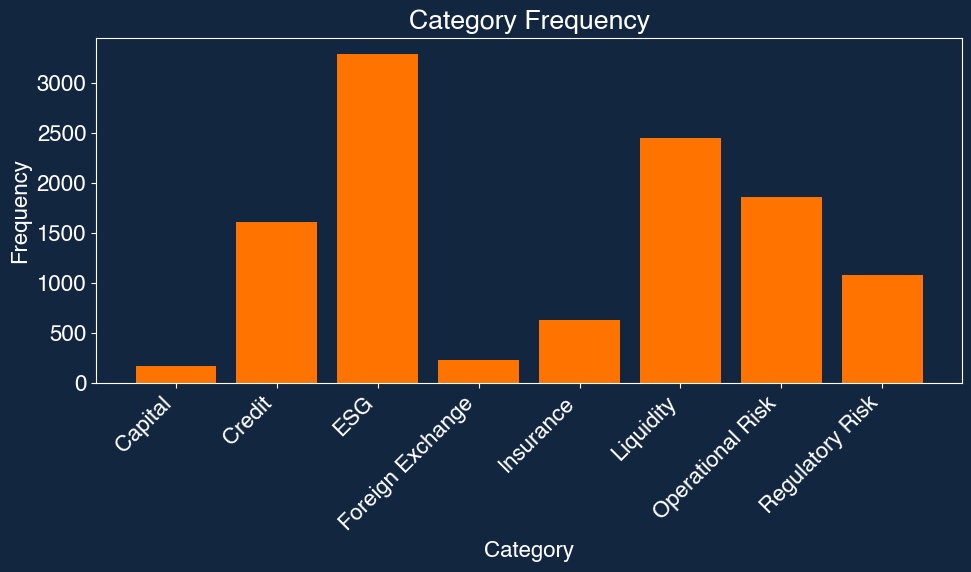

In [13]:
text_hsbc = extractPDF('src/hsbc/230221-annual-report-and-accounts-2022.pdf')
df_hsbc = searchPDF(text_hsbc)
plot_category_frequency(df_hsbc)

Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 1672 ticks ([-1.0, ..., 1670.0]),

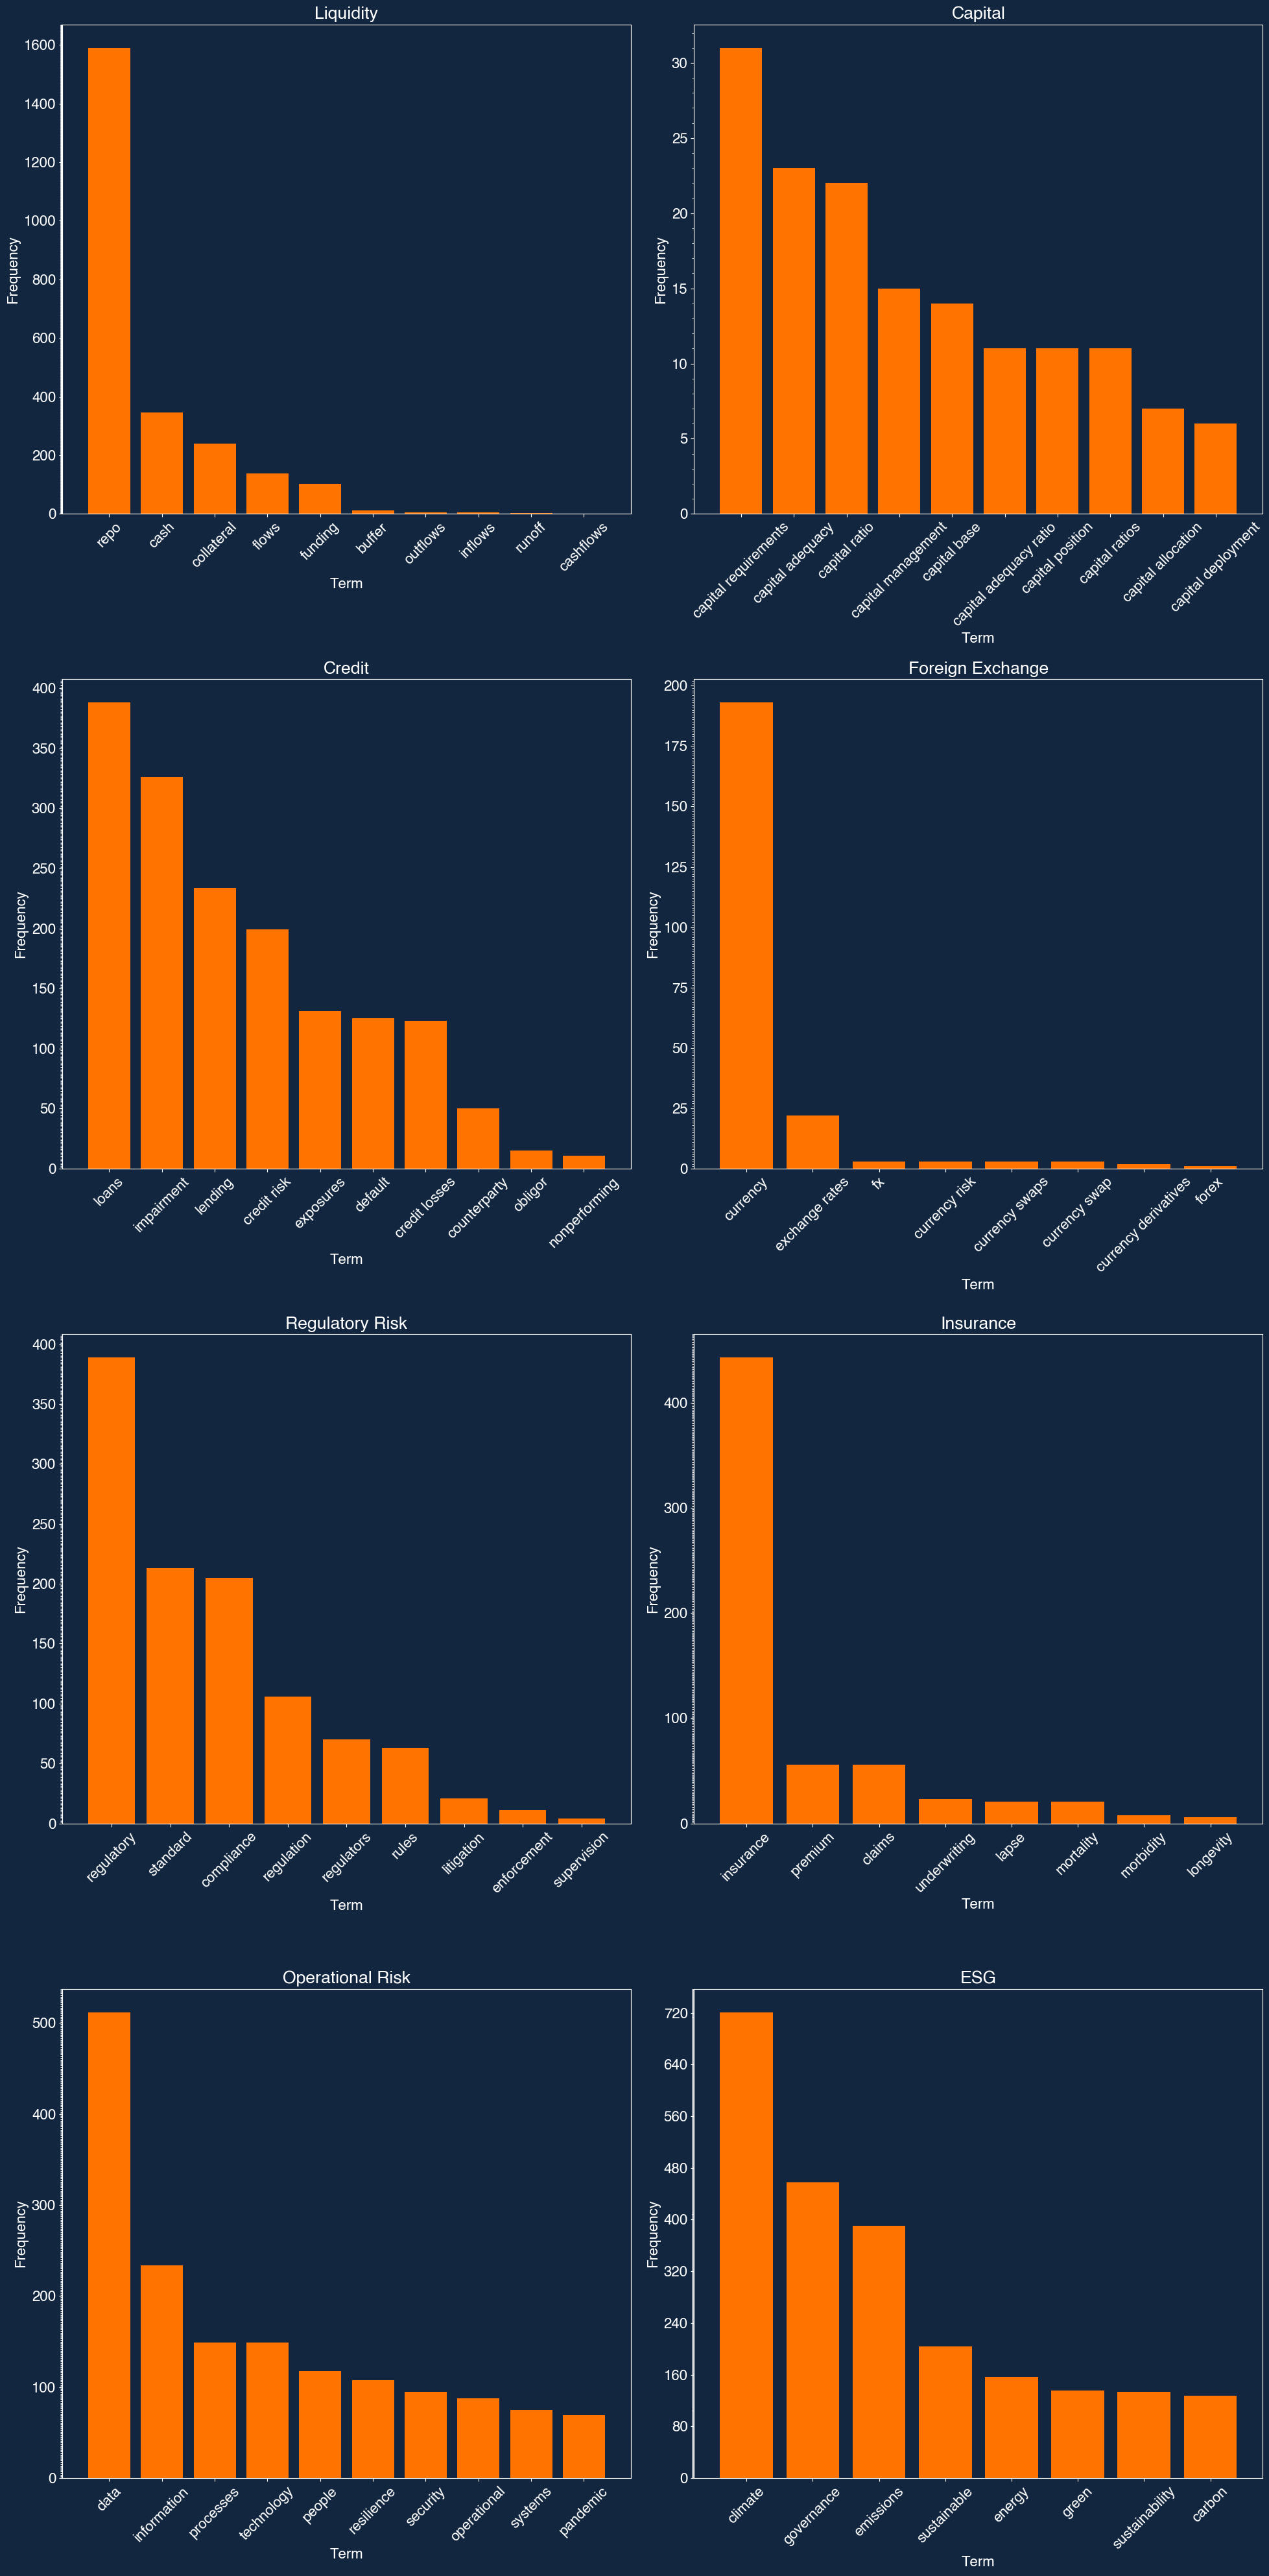

In [14]:
categories = df_hsbc['Category'].unique()
total_cats = len(categories)
cols = 2
rows = math.ceil(total_cats / cols) # how many rows, rounded to nearest whole int, do we need to display all categories?

fig, axs = plt.subplots(rows, cols, figsize=(20, 10 * rows))
axs = axs.flatten()

# loop over each categories and plot each one
for i, category in enumerate(categories):
    ax = axs[i]
    plot_category(10, category, df_hsbc, ax=ax)
    
axs[i].yaxis.set_major_locator(MaxNLocator(nbins=10)) # set the number of y ticks to 10
#TODO: change Locator.MAXTICKS constraint
plt.tight_layout()
plt.show()

# Comparison between the two

The token count is far greater in the HSBC AR than JPM - making cross-comparisons relatively ineffective.\
However, a comparison matrix acts as an interesting proof of concept.

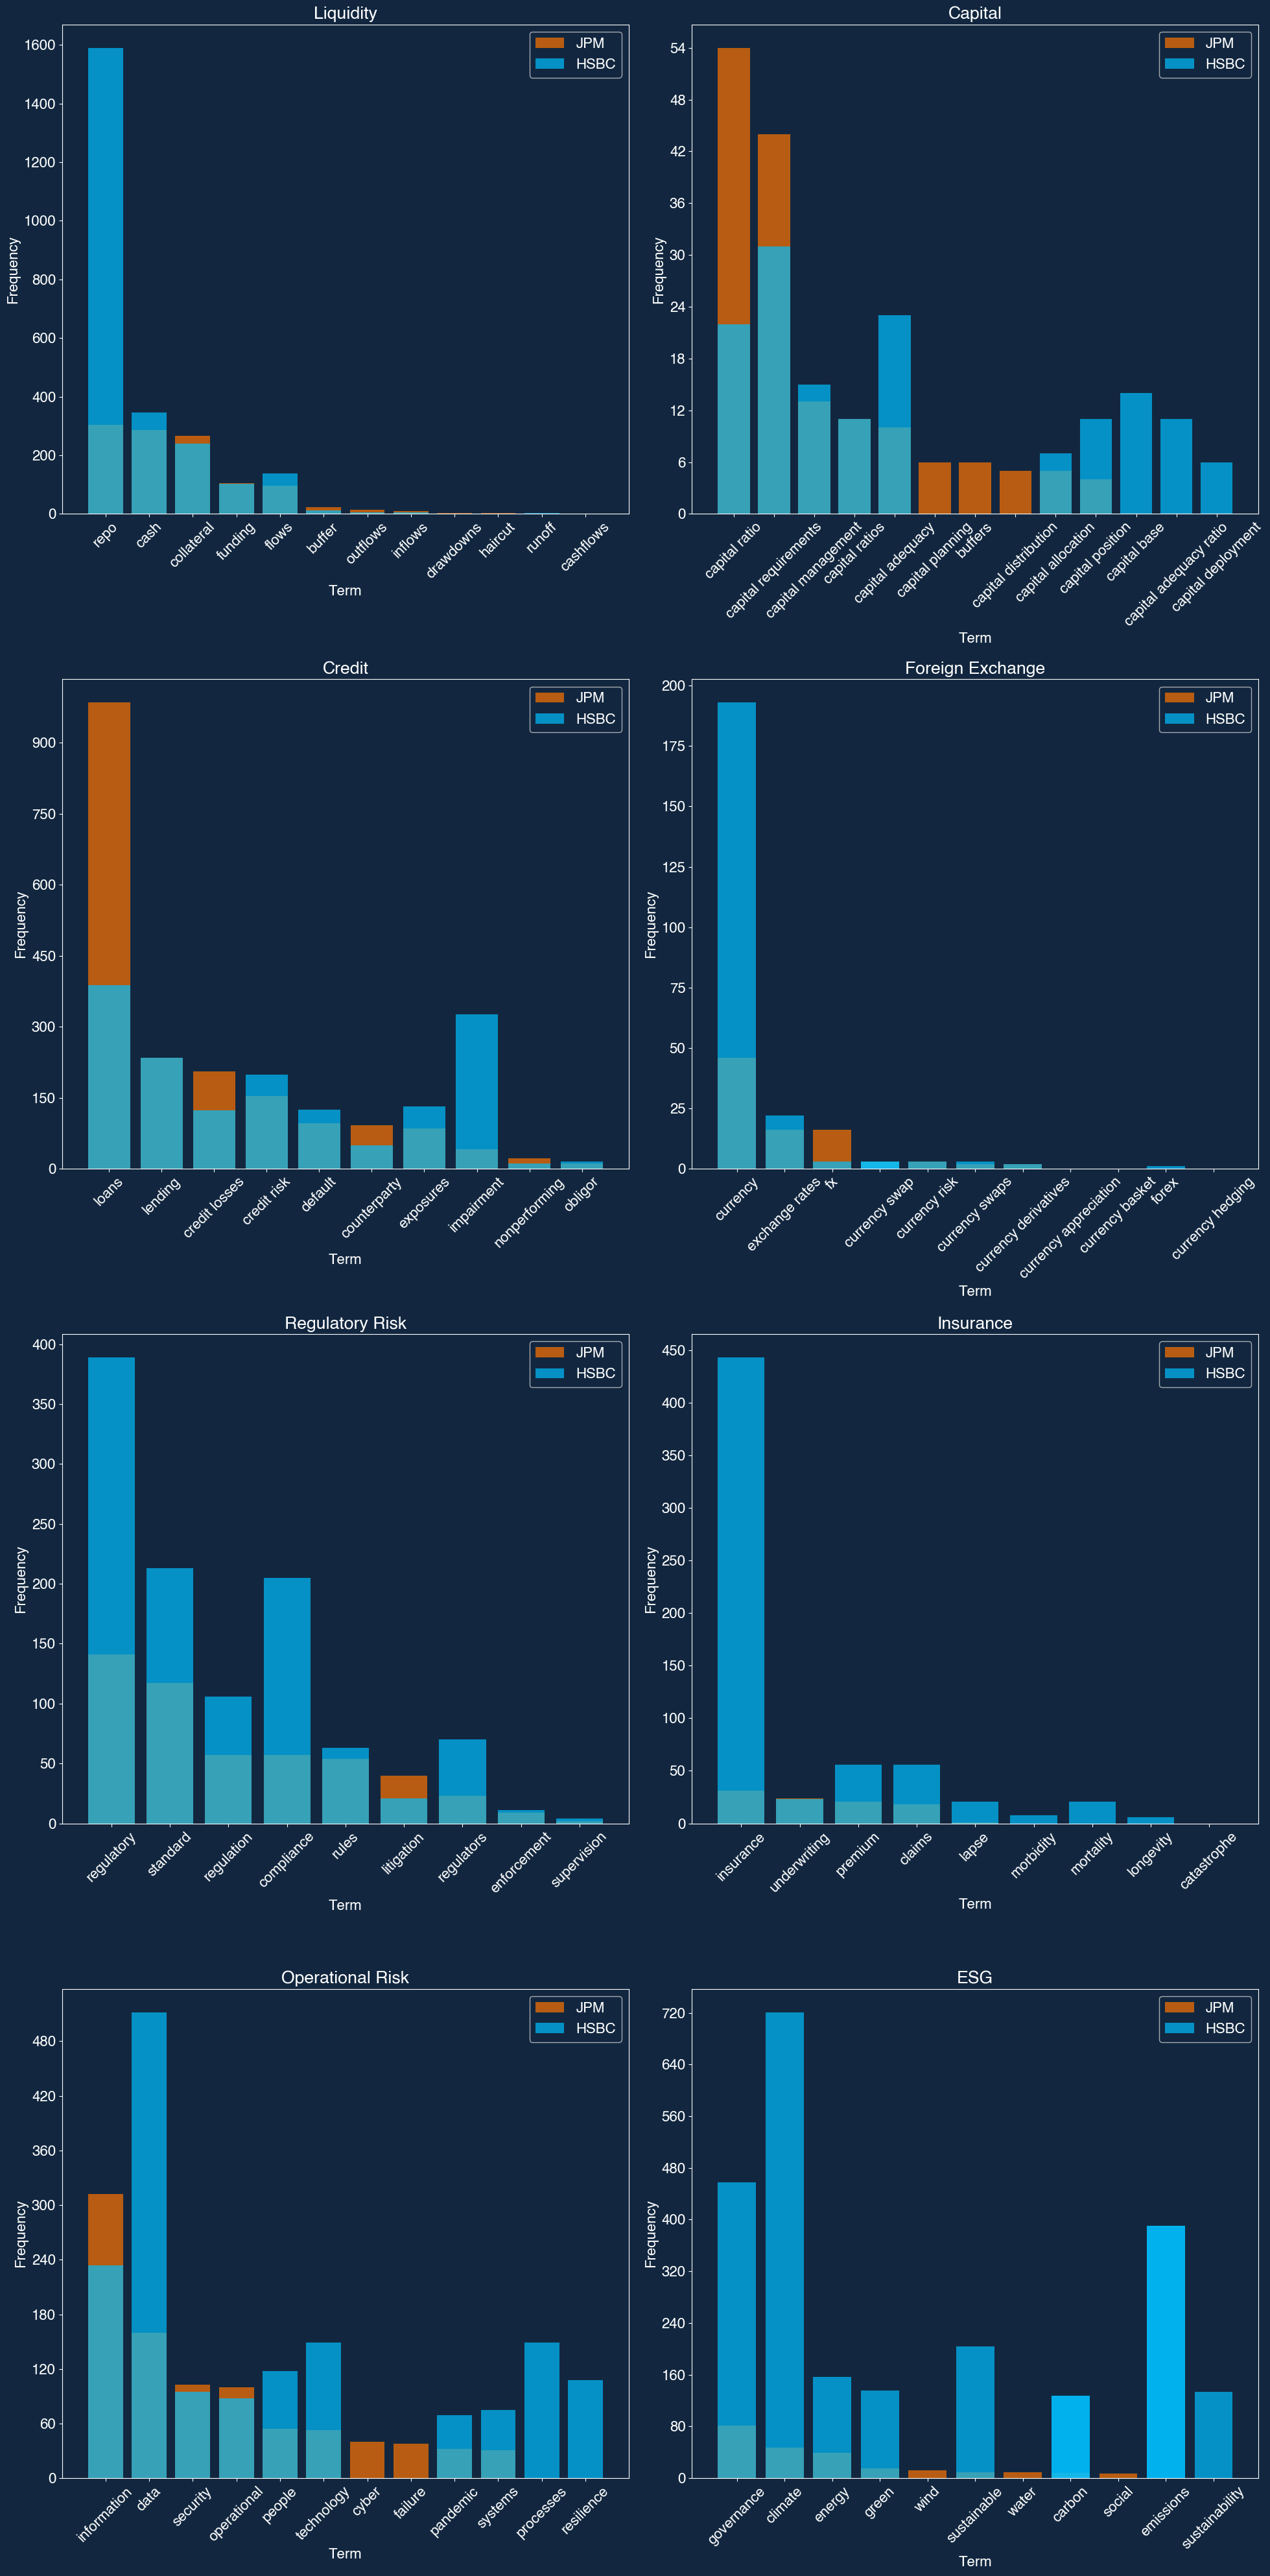

In [15]:
categories = jpm_df['Category'].unique()
n = len(categories)    
cols = 2
rows = math.ceil(n / cols)

fig, axs = plt.subplots(rows, cols, figsize=(20, 10 * rows))
axs = axs.flatten()

# loop over each category and plot JPM vs HSBC side by side
for i, category in enumerate(categories):
    category_jpm_df = jpm_df[jpm_df['Category'] == category]
    category_df_hsbc = df_hsbc[df_hsbc['Category'] == category]
    
    category_jpm_df = category_jpm_df.sort_values(by='Frequency', ascending=False)
    category_df_hsbc = category_df_hsbc.sort_values(by='Frequency', ascending=False)
    
    # top 10 terms for each report
    top_words_jpm = category_jpm_df.iloc[:10]['SearchTerm'] 
    top_frequencies_jpm = category_jpm_df.iloc[:10]['Frequency']
    
    top_words_hsbc = category_df_hsbc.iloc[:10]['SearchTerm']
    top_frequencies_hsbc = category_df_hsbc.iloc[:10]['Frequency']
    
    # JPM data (orange bars)
    axs[i].bar(top_words_jpm, top_frequencies_jpm, color='#FF7300', alpha=0.7, label='JPM')
    # HSBC data (blue bars)
    axs[i].bar(top_words_hsbc, top_frequencies_hsbc, color='#00BFFF', alpha=0.7, label='HSBC')
    
    axs[i].set_title(category)
    axs[i].set_xlabel('Term')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].tick_params(axis='y')
    
    axs[i].yaxis.set_major_locator(MaxNLocator(nbins=10))
    axs[i].legend()

plt.tight_layout()
plt.show()

# N-gram analysis

N-grams are contiguous sequences of $n$ items from a given sample of text or speech.\
\
They can be unigrams (single words), bigrams (pairs of words), trigrams (triplets of words), or higher-order n-grams.\
N-grams help capture the context and structure of a corpus by considering the co-occurrence of words, which allows for at-a-glance sentiment analysis or frequently mentioned points discussed in the corpus.

## N-gram extraction

**Data source: JPM Annual Report 2022**

Despite extractPDF() cleaning the initial text, it is not good enough to be 'lemmatised'\
Lemmatisation is the process of reducing words to their base or dictionary form, or the *lemma*.\
For example, converting "running" to "run" or "better" to "good".

In [22]:
def ngram_clean(doc):
    wnl = nltk.WordNetLemmatizer()
    text = extractPDF(doc) 
    # text normalisation:
        # NFKD normalisation - Unicode Normalization Form (k) Compatibility Decomposition (https://unicode.org/reports/tr15/)
        # normalised unicode -> ascii to remove non-ascii standard chars -> decode back to utf-8 -> lowercase
    text = (unicodedata.normalize('NFKD', text)
            .encode('ascii', 'ignore')
            .decode('utf-8', 'ignore')
            .lower())
    words = re.sub(r'[^\w\s]', '', text).split() # remove punctuation and split into words
    return [wnl.lemmatize(word) for word in words if word not in stopwords.words('english')] # remove stopwords and lemmatise

def ngram(n, topn, path):
    tokens = (pd.Series(nltk.ngrams(ngram_clean(path), n)).value_counts())[:topn] 
    # where n is the n-gram size, and topn is the number of top n-grams to be visualised
    return tokens

In [23]:
start_time = time.time()
text = 'src/jpm/NYSE_JPM_2022.pdf'

unigrams = ngram(1, 10, text) #n=1
bigrams = ngram(2, 10, text) #n=2
trigrams = ngram(3, 10, text) #n=3
quadgrams = ngram(4, 10, text) #n=4

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 16.98 seconds


## N-gram visualisaton (bar)

The efficacy of n-gram visualisation is dependent on the corpus quality. \
The JPM AR does not lend well to n-gram analysis beyond n=2 due to prevalence of unnecessary terms.   

### n=1, n=2

Text(0.5, 1.0, 'Bigram Analysis')

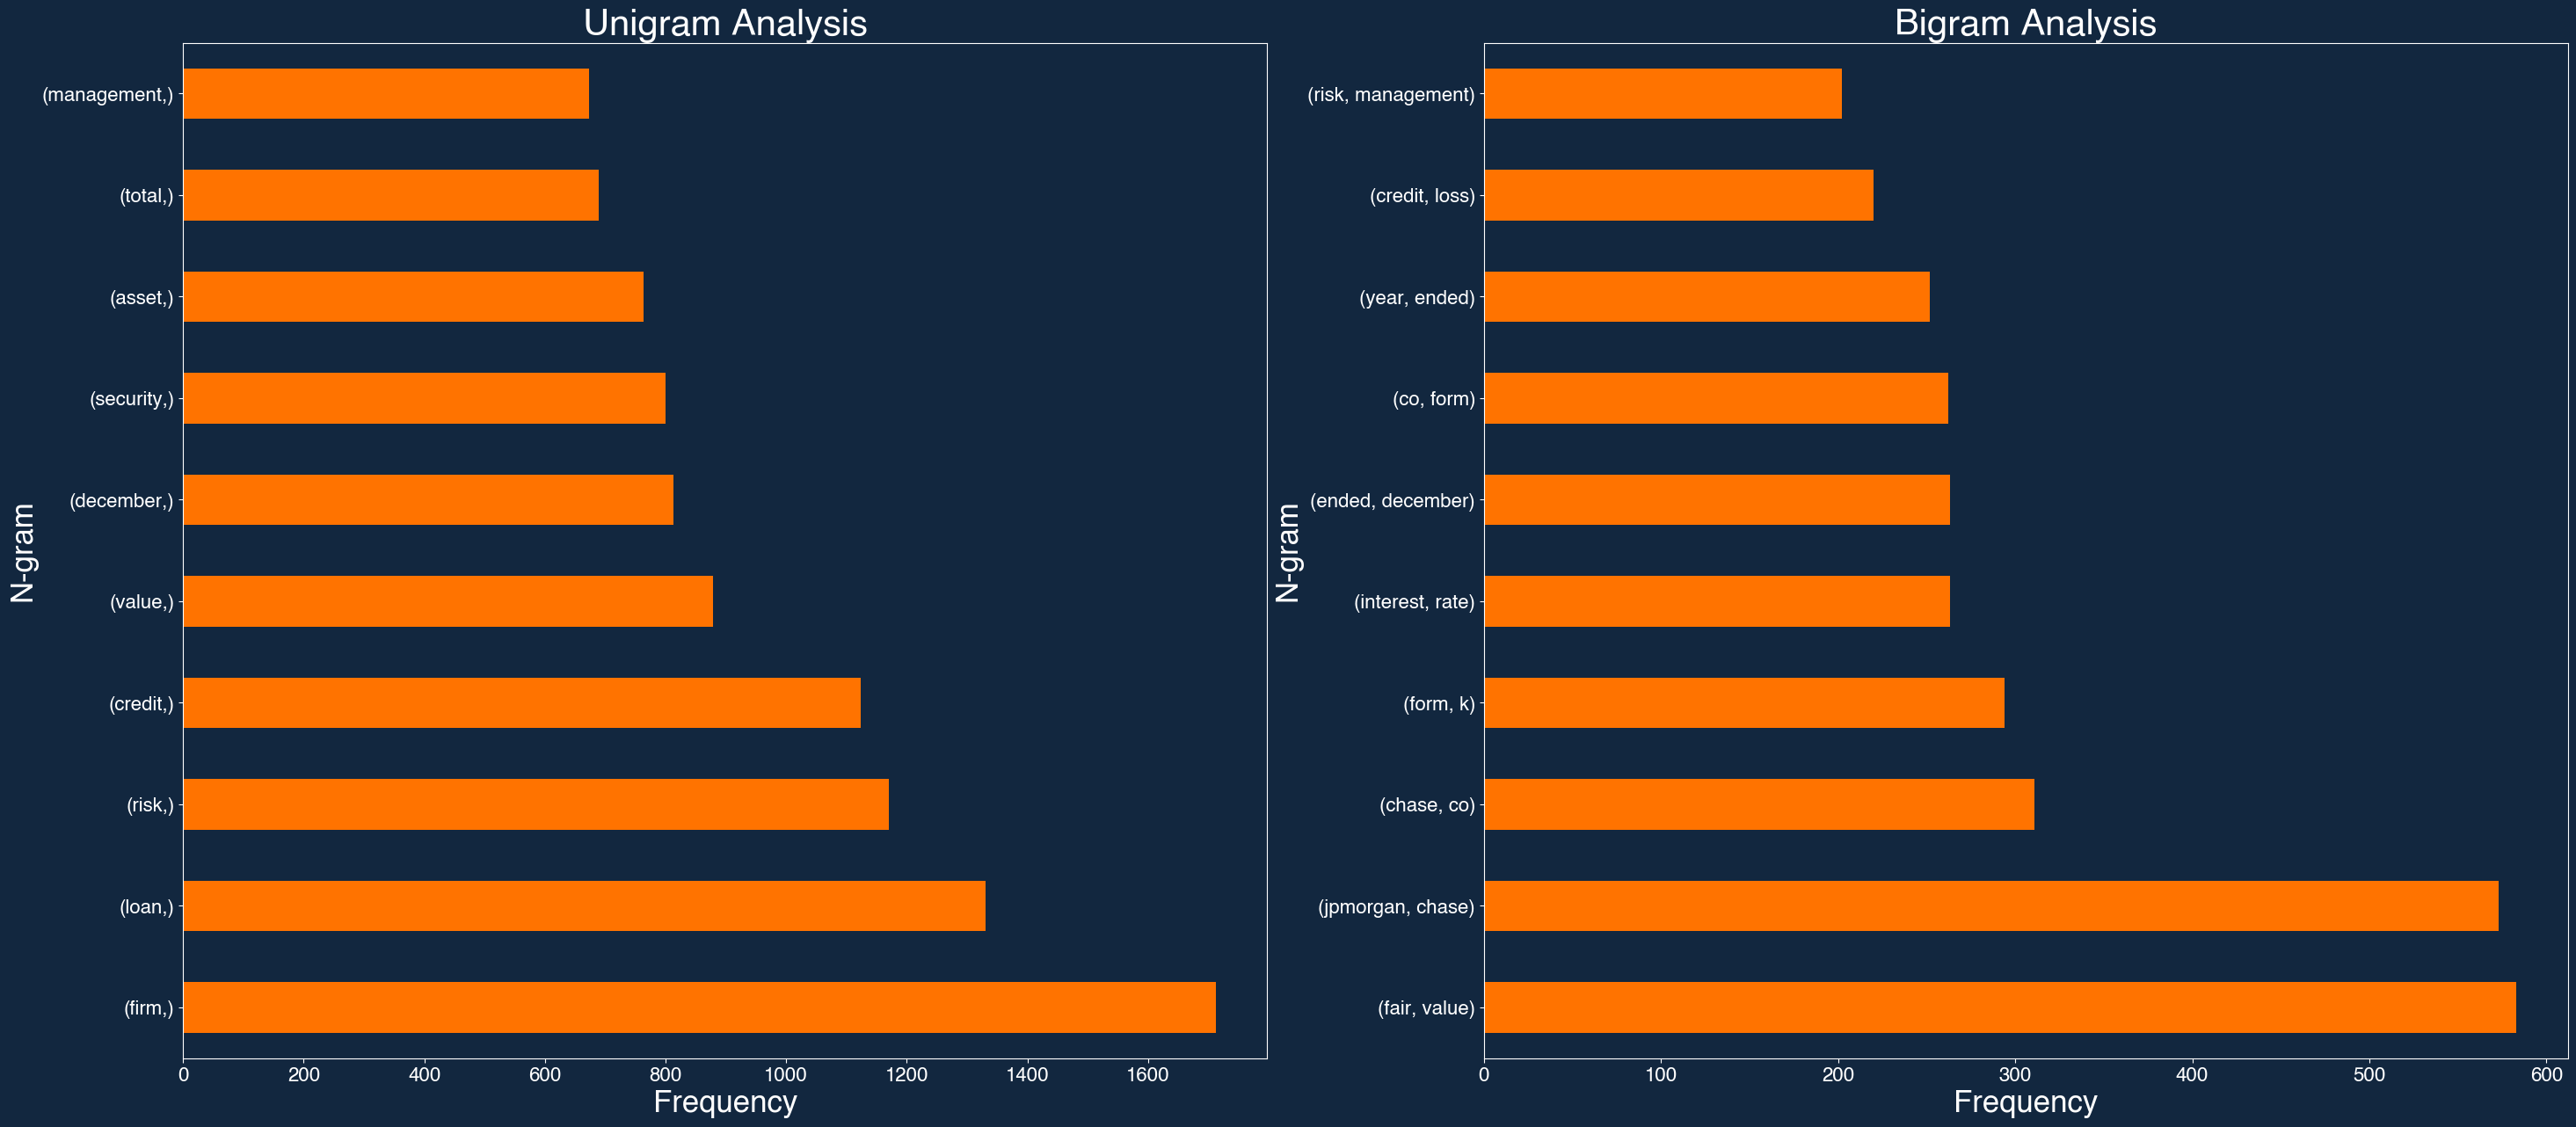

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(35, 15))

# unigram counts
unigrams.plot(kind='barh', color='#FF7300', ax=axs[0])
axs[0].set_xlabel('Frequency', fontsize= 25)
axs[0].set_ylabel('N-gram', fontsize=25)
axs[0].set_title('Unigram Analysis', fontsize=30)

# bigram counts
bigrams.plot(kind='barh', color='#FF7300', ax=axs[1])
axs[1].set_xlabel('Frequency', fontsize= 25)
axs[1].set_ylabel('N-gram', fontsize=25)
axs[1].set_title('Bigram Analysis', fontsize=30)

### n=3, n=4

In [19]:
def wrap_labels(ax, width):
    labels = [label.get_text() for label in ax.get_yticklabels()] # get the current y-axis labels
    wrapped_labels = ['\n'.join(textwrap.wrap(label, width)) for label in labels] # wrap the labels to width
    ax.set_yticklabels(wrapped_labels, rotation=0)

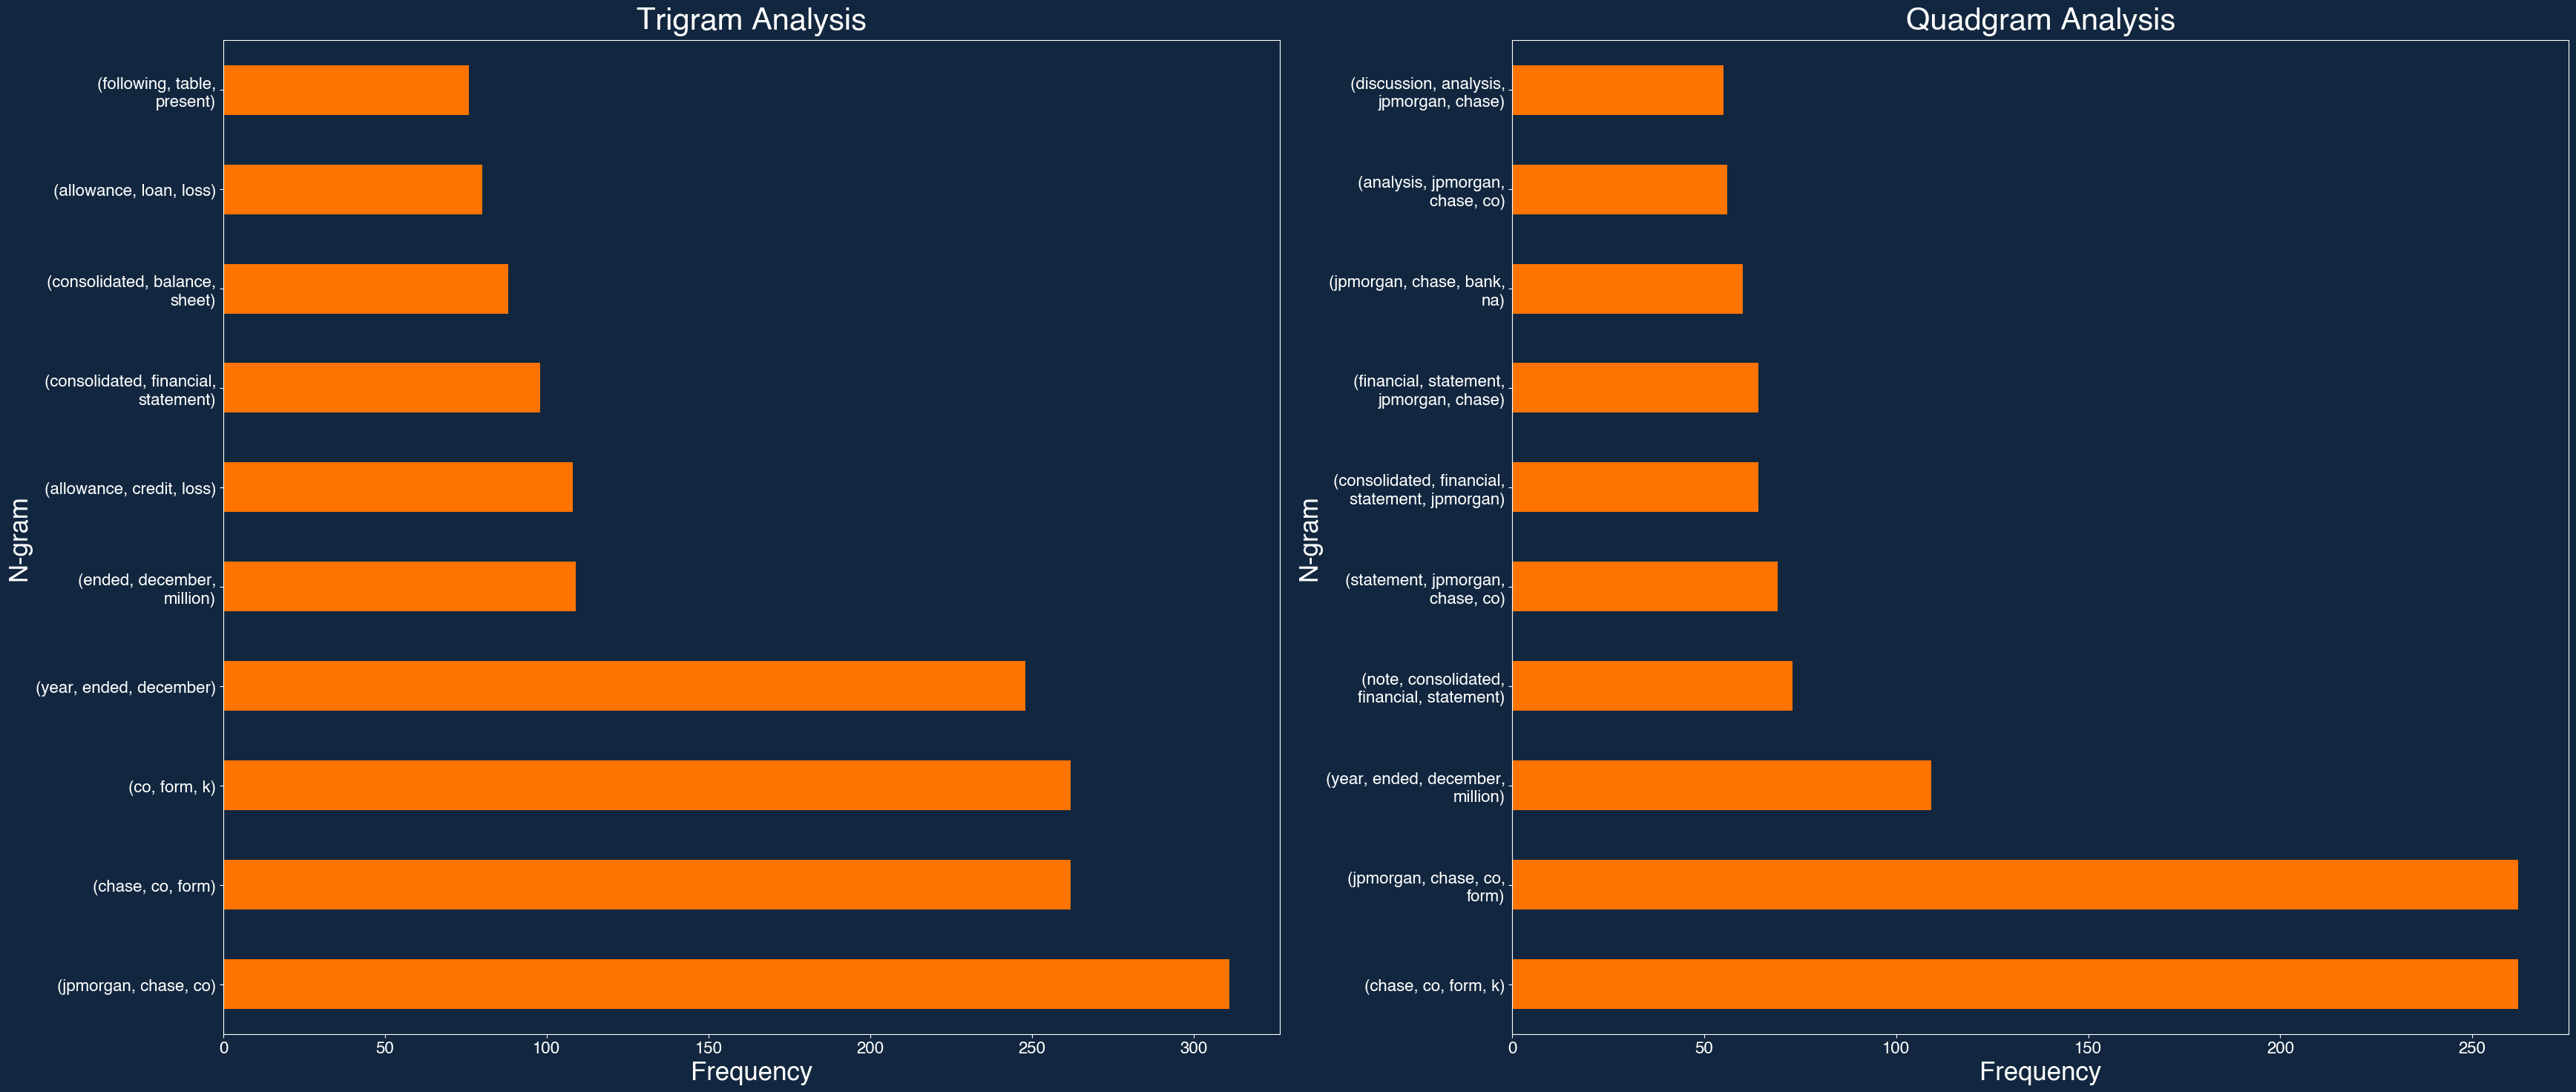

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(35, 15))

# trigram counts
trigrams.plot(kind='barh', color='#FF7300', ax=axs[0])
axs[0].set_xlabel('Frequency', fontsize=25, y=1.005)
axs[0].set_ylabel('N-gram', fontsize=25)
axs[0].set_title('Trigram Analysis', fontsize=30, y=1.005)
wrap_labels(axs[0], 25)  

# quadgram counts
quadgrams.plot(kind='barh', color='#FF7300', ax=axs[1])
axs[1].set_xlabel('Frequency', fontsize=25, y=1.005)
axs[1].set_ylabel('N-gram', fontsize=25)
axs[1].set_title('Quadgram Analysis', fontsize=30, y=1.005)
wrap_labels(axs[1], 25) 

plt.tight_layout()
plt.show()

## N-gram visualisation (worldcloud)

### n=1, n=2

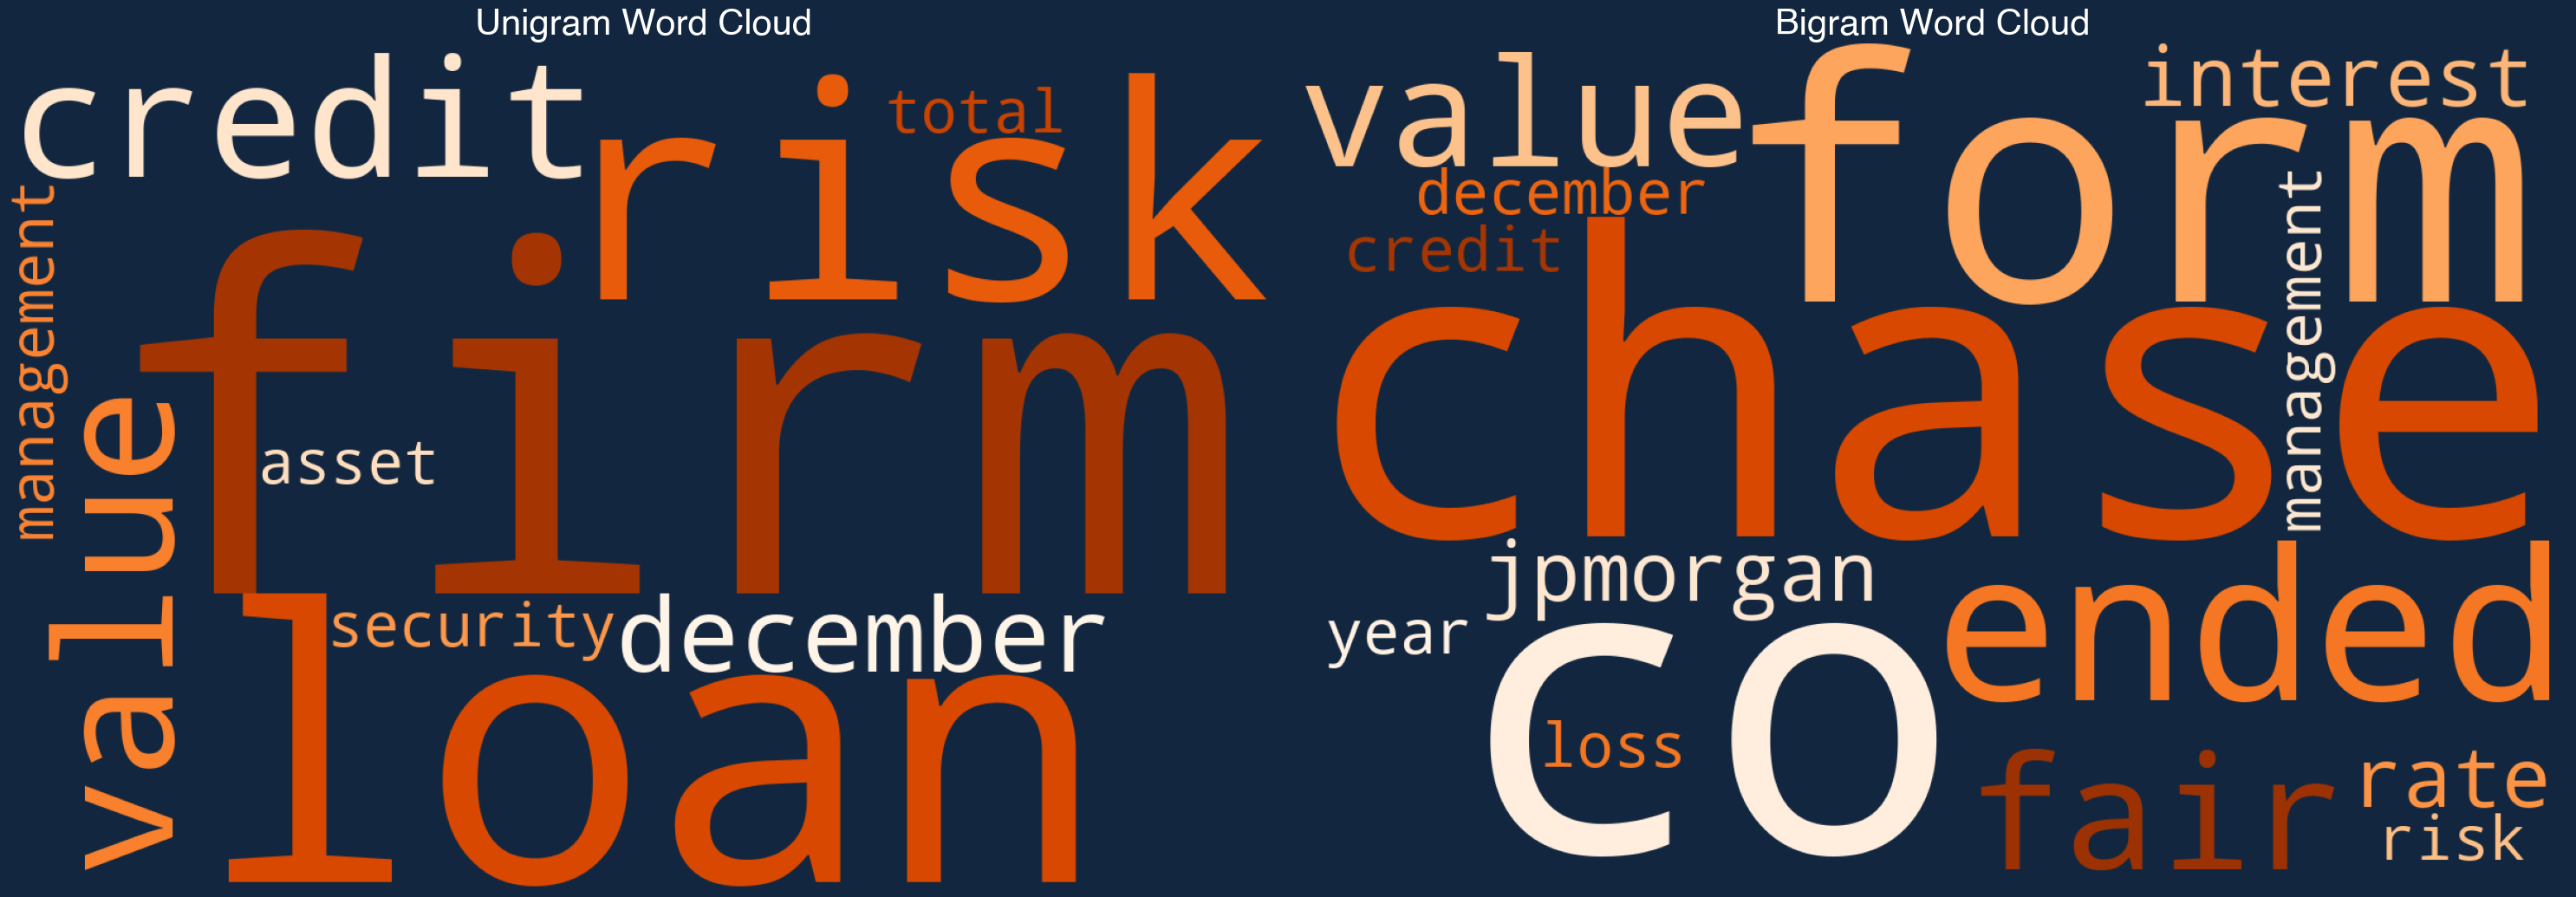

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

unigram_wc = WordCloud(
    background_color='#12273F',  # Match figure.facecolor
    colormap='Oranges',          # Use orange colormap to match bar charts
    width=1200,
    height=800
).generate(unigrams.to_string())

bigram_wc = WordCloud(
    background_color='#12273F',
    colormap='Oranges', 
    width=1200,
    height=800
).generate(bigrams.to_string())

ax1.imshow(unigram_wc)
ax1.axis('off')
ax1.set_title('Unigram Word Cloud', fontsize=30, fontweight='bold')

ax2.imshow(bigram_wc)
ax2.axis('off')
ax2.set_title('Bigram Word Cloud', fontsize=30, fontweight='bold')

plt.tight_layout()
plt.show()

### n=3, n=4

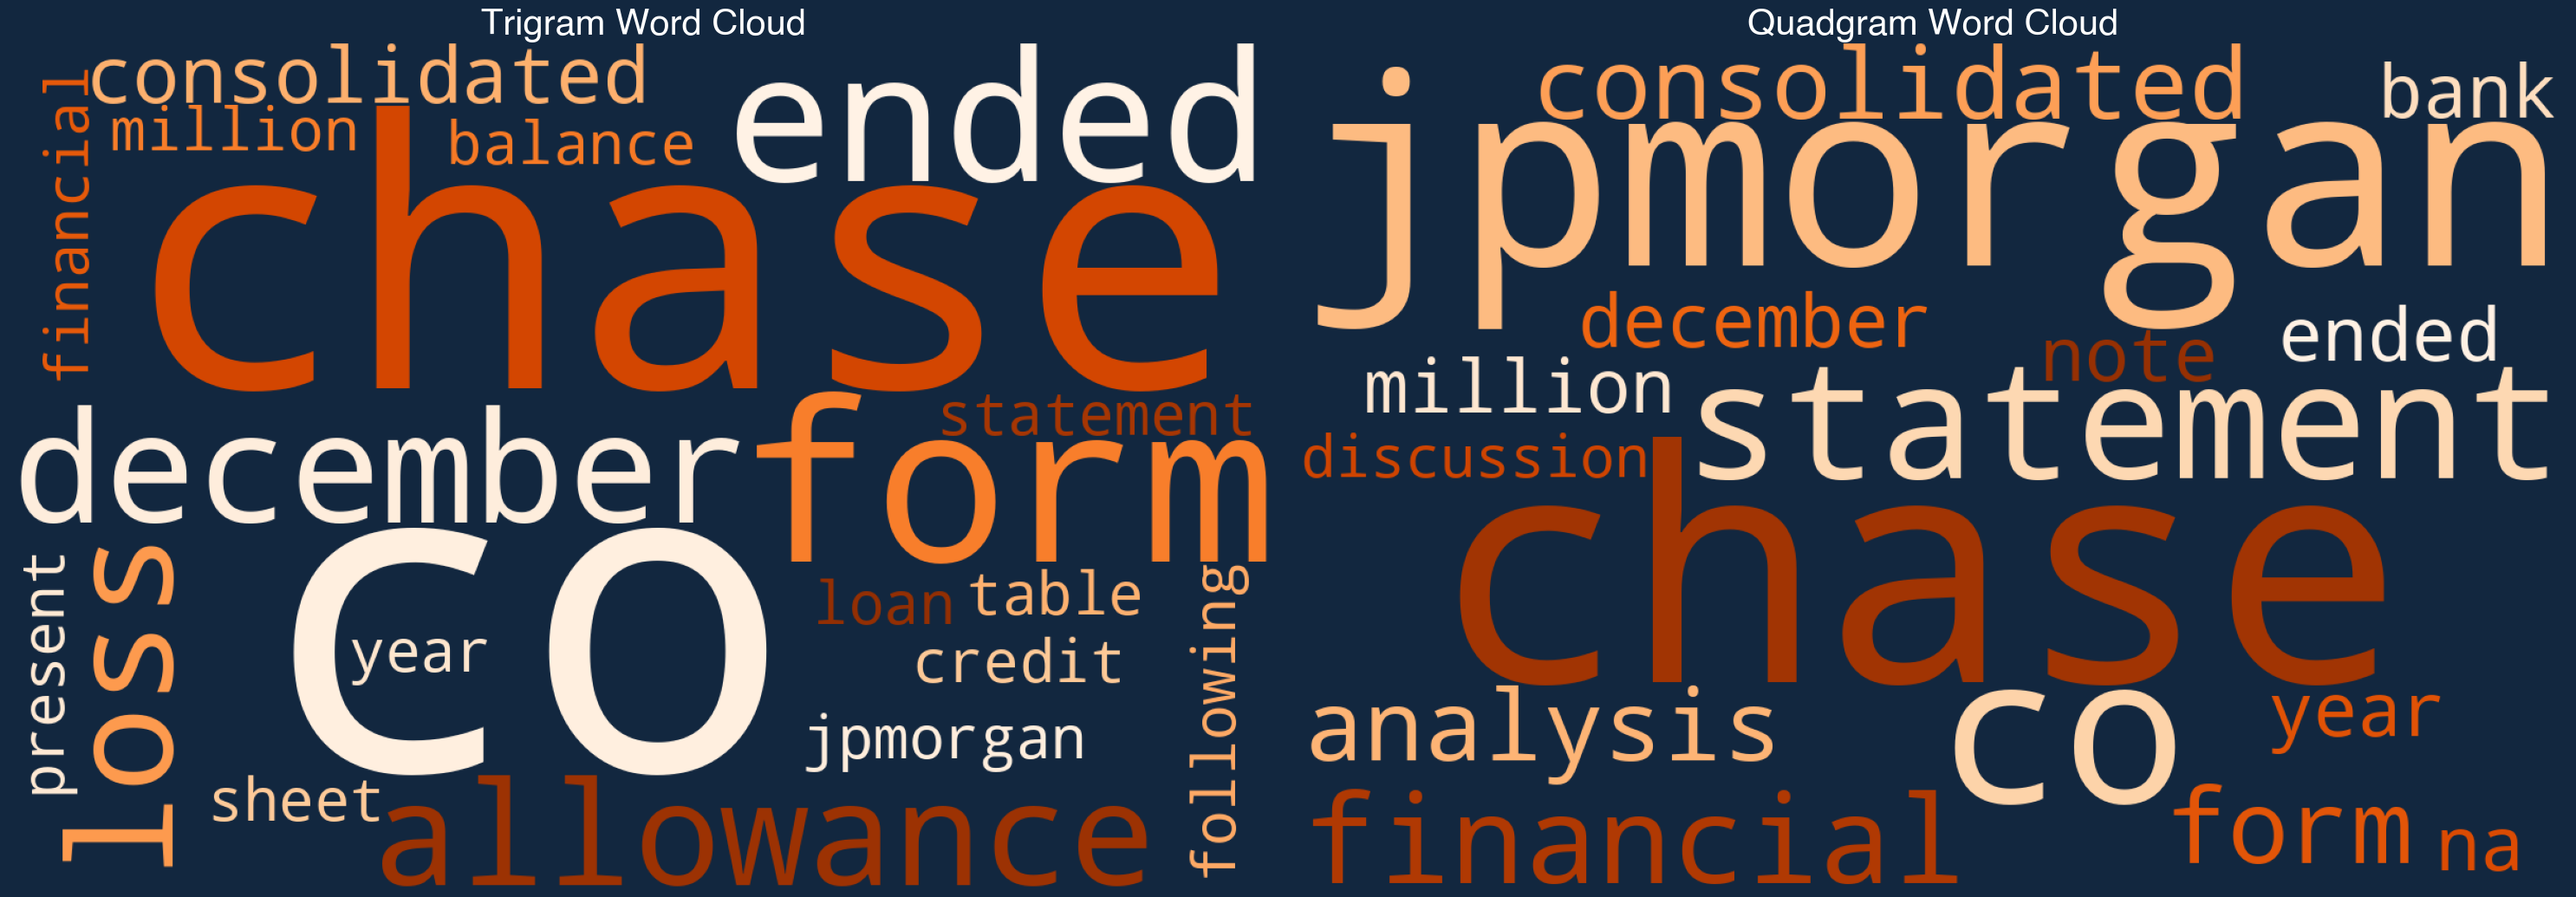

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))

trigram_wc = WordCloud(
    background_color='#12273F',  
    colormap='Oranges',        
    width=1200,
    height=800
).generate(trigrams.to_string())

quadgram_wc = WordCloud(
    background_color='#12273F',
    colormap='Oranges', 
    width=1200,
    height=800
).generate(quadgrams.to_string())

ax1.imshow(trigram_wc)
ax1.axis('off')
ax1.set_title('Trigram Word Cloud', fontsize=30, fontweight='bold')

ax2.imshow(quadgram_wc)
ax2.axis('off')
ax2.set_title('Quadgram Word Cloud', fontsize=30, fontweight='bold')

plt.tight_layout()
plt.show()